# Analysis of the nucleus of NGC7319

This notebook will provide an initial overview of the 3D MRS cube and/or the 1D extracted spectra form the JWST pipeline. It performs the following analysis:
<br>
* Plot the full spectra of NGC7319 and identify the main detected emission lines
* Perform a zoom to an emission line
* Analize an emission line. Emission line fitting and flux calculation.
* Analize the spatial distribution of an emission line in the MRS FoV. Generate a emission line map.

Analyses of the JWST MRS of NGC7319 galaxy could be found in the following papers:

* Pereira-Santaella et al. (2022), A&A, 665, L11 https://ui.adsabs.harvard.edu/abs/2022A%26A...665L..11P/abstract
* Garcia-Bernete et al. (2022), A&A, 666, L5 https://ui.adsabs.harvard.edu/abs/2022A%26A...666L...5G/abstract

This is the list of the main emission lines detected in the 1D extracted spectrum of NGC7319:
<br>
Note: All wavelengths are in um and vacuum
<br>
* H2(0-0)S(8)  5.05312
<br>
* [FeII]       5.340169
<br>
* [MgVII]      5.503200
<br>
* H2(0-0)S(7)  5.51118
<br>
* [MgV]        5.609850
<br>
* H2(0-0)S(6)  6.10857
<br>
* H2(0-0)S(5)  6.90952
<br>
* [ArII]       6.985274
<br>
* [NeVI]       7.652400
<br>
* H2(0-0)S(4)  8.02505
<br>
* [ArIII]      8.991380
<br>
* [FeVII]      9.526700
<br>
* H2(0-0)S(3)  9.6649
<br>
* [SIV]        10.510500
<br>
* H2(0-0)S(2)  12.27861
<br>
* [NeII]       12.813550
<br>
* [ArV]        13.102200
<br>
* [NeV]        14.321700 
<br>
* [NeIII]      15.555100
<br>
* H2(0-0)S(1)  17.03484
<br>
* [SIII]       18.713000
<br>
* [NeV]        24.317500
<br>
* [OIV]        25.890300 

This Notebook is generated by Javier Álvarez-Márquez (questions to javier.alvarez@cab.inta-csic.es)

## 1. Set up the notebook

#### 1.1 Imports

In [1]:
import os
import numpy as np

from astropy.io import fits

import matplotlib.pyplot as plt
from matplotlib import rc
import astropy.visualization as vis
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size

from photutils.centroids import centroid_2dg, centroid_com, centroid_sources

import copy
from mpfit import mpfit

# Now let's use the entire available screen width for the notebook
from IPython.display import display, HTML
#display(HTML("<style>.container { width:95% !important; }</style>"))

#### 1.2 Define directories

In [2]:
dir_MRScubes = '/home/cysil/JWST/projects/IFU_MRS/Data/Source/stage3/'
dir_1Dspectra = '/home/cysil/JWST/projects/IFU_MRS/Data/Source/stage3/'

dir_output = '/home/cysil/JWST/projects/IFU_MRS/Plots/'

if not os.path.exists(dir_output):
    os.makedirs(dir_output)

#### 1.3 Define parameters and variables 

In [3]:
#information about the MRS channels and bands
Channels = ['1','2','3','4']
Bands = ['SHORT', 'MEDIUM', 'LONG']

#information about the redshift of the astronomical source
redshift = 0.02251

## 2. Nuclear spectrum of NGC7319
Here we plot the full MRS spectrum of NGC7319, thogether with the identification of the main emission lines

#### 2.1 Define the emission lines that you have identified in the MRS spectrum

Note 1: if you want to analize other kind of astronomical sources, your will need to identify here the most commom emission lines in each of the MRS channels
<br>
Note 2: Here a webpage with the most important emission lines in the Mid-IR, https://www.mpe.mpg.de/ir/ISO/linelists/index.html 

In [4]:
Lines = True # This should be set to True if you want to overplot the emission line identification

Ch1_name_line = ['S(8)', '[FeII]', '[MgVII]', 'S(7)', '[MgV]', 'S(6)', 'S(5)', '[ArII]']
ch1_lambda_line = np.array([5.05312, 5.340169, 5.503200, 5.51118, 5.609850, 6.10857, 6.90952, 6.985274])
Ch1_loc_line =  np.array([-0.09, -0.11, -0.15, 0.01, 0.01, 0.01, -0.09,0.01])
y_loc_name_ch1 = 32

Ch2_name_line = ['[NeVI]', 'S(4)', '[ArIII]', '[FeVII]', 'S(3)', '[SVI]']
ch2_lambda_line = np.array([7.6524, 8.02505, 8.99138,9.5267,9.6649, 10.5105])
Ch2_loc_line =  np.array([0.015, 0.015, 0.015, -0.2, 0.015, 0.015])
y_loc_name_ch2 = 85

Ch3_name_line = ['S(2)', '[NeII]', '[ArV]', '[NeV]', '[NeIII]', 'S(1)']
ch3_lambda_line = np.array([12.27861, 12.813550, 13.102200, 14.321700, 15.555100, 17.03484])
Ch3_loc_line =  np.array([0.025, 0.025, 0.025, 0.025, 0.025, 0.025])
y_loc_name_ch3 = 300

Ch4_name_line = ['[SIII]', '[NeV]','[OIV]']
ch4_lambda_line = np.array([18.713, 24.3175, 25.8903])
Ch4_loc_line =  np.array([0.04, 0.04, -0.45])
y_loc_name_ch4 = 1000

#### 2.2 Visualization of the full MRS spectrum and emission line identification

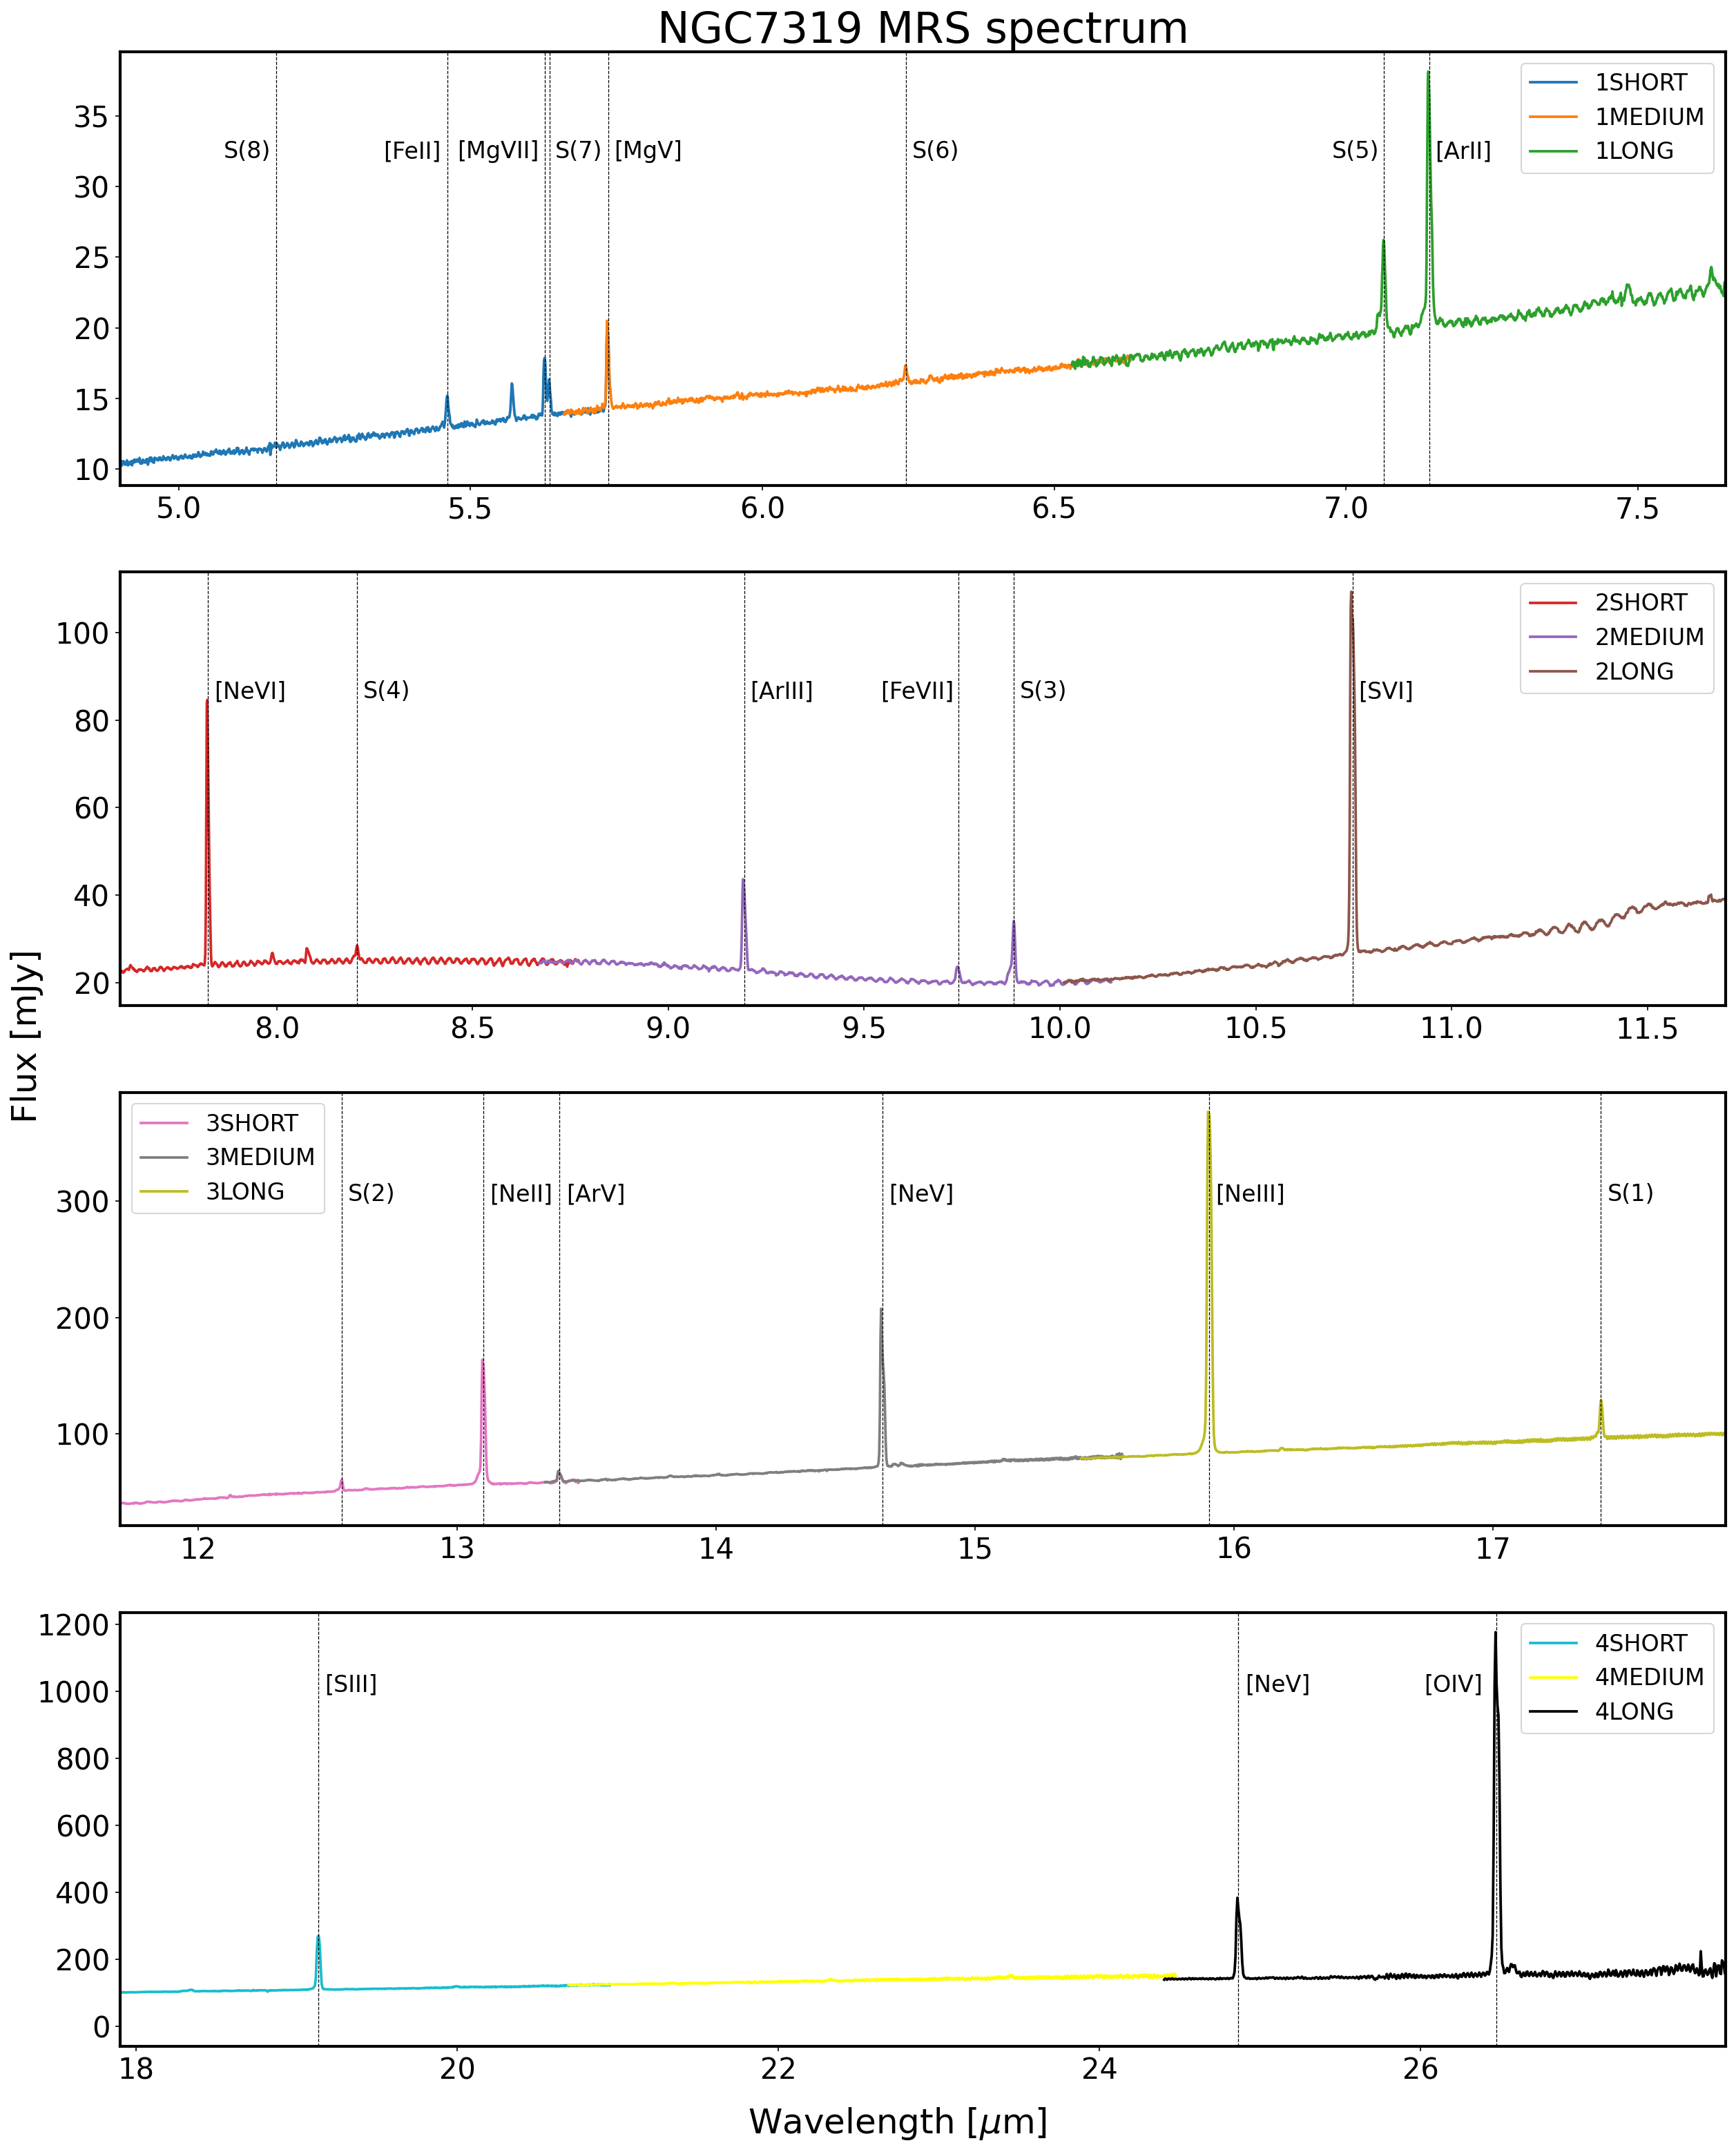

In [5]:
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan','yellow','k']

rc('axes', linewidth=2)
fig, axs = plt.subplots(4, 1, figsize=(20, 25), dpi=150)

index = int(0)
for i in range(len(Channels)):
    for j in range(len(Bands)):
    
        file = dir_1Dspectra + 'Level3_ch{}-{}_x1d.fits'.format(Channels[i], Bands[j].lower())
        x1d=fits.open(file)
        x1ddata=x1d[1].data
        wave=x1ddata['WAVELENGTH'] # um
        flux=x1ddata['FLUX'] * 1.e+3 #mJy
        
        axs[i].plot(wave, flux, color=colors[index], linewidth=1.8, label=Channels[i]+Bands[j])
        index = index + int(1)
    
    axs[i].tick_params(axis="x", labelsize=20)
    axs[i].tick_params(axis="y", labelsize=20)

    axs[i].legend(fontsize=16)
    
    axs[0].set_xlim(4.9,7.65)
    axs[1].set_xlim(7.6,11.7)
    axs[2].set_xlim(11.7,17.9)
    axs[3].set_xlim(17.9,27.9)

if Lines == True:
    y_name = [y_loc_name_ch1, y_loc_name_ch2, y_loc_name_ch3, y_loc_name_ch4] 
    for k in range(len(Ch1_name_line)):
        axs[0].axvline(x = ch1_lambda_line[k]*(1+redshift), color = 'k', linestyle='--', linewidth=0.6)
        axs[0].text(ch1_lambda_line[k]*(1+redshift)+Ch1_loc_line[k], y_name[0], Ch1_name_line[k], size=16) 
    for k in range(len(Ch2_name_line)):
        axs[1].axvline(x = ch2_lambda_line[k]*(1+redshift), color = 'k', linestyle='--', linewidth=0.6)
        axs[1].text(ch2_lambda_line[k]*(1+redshift)+Ch2_loc_line[k], y_name[1], Ch2_name_line[k], size=16) 
    for k in range(len(Ch3_name_line)):
        axs[2].axvline(x = ch3_lambda_line[k]*(1+redshift), color = 'k', linestyle='--', linewidth=0.6)
        axs[2].text(ch3_lambda_line[k]*(1+redshift)+Ch3_loc_line[k], y_name[2], Ch3_name_line[k], size=16) 
    for k in range(len(Ch4_name_line)):
        axs[3].axvline(x = ch4_lambda_line[k]*(1+redshift), color = 'k', linestyle='--', linewidth=0.6)
        axs[3].text(ch4_lambda_line[k]*(1+redshift)+Ch4_loc_line[k], y_name[3], Ch4_name_line[k], size=16) 

fig.axes[0].set_title(r'NGC7319 MRS spectrum', fontsize=30, va='center', ha='center')
    
fig.axes[0].set_ylabel(r'Flux [mJy]', fontsize=24, va='center', ha='center')
fig.axes[0].yaxis.set_label_coords(0.08, 0.5, transform=fig.transFigure)
fig.axes[0].autoscale_view()

fig.axes[0].set_xlabel(r'Wavelength [$\mu$m]', fontsize=24, va='center', ha='center')
fig.axes[0].xaxis.set_label_coords(0.5, 0.08, transform=fig.transFigure)
fig.axes[0].autoscale_view()



plt.savefig(dir_output + 'NGC7913_spectrum.pdf',format='pdf',bbox_inches='tight')

plt.show()

## 3. Visualization and zoom into an emission line
Here we perform a zoom to an emission line. Please, if you want to vizualize different emission lines you should run this section again modifing the parameters of Section 3.1

#### 3.1 Define the parameters of the emission line

In [6]:
# Define the emission line that you whould like to visualize
name_line = '[NeII]'  
lambda_line = 12.813550  # um
min_velocity = -2000      # km/s
max_velocity = 2000       # km/s

# Which does MRS channel contain the emission line?
channel_line = '3'   # 1, 2, 3, or 4
band_line = 'SHORT'  # SHORT, MEDIUM, or LONG 

#### 3.2 Load the spectrum and set up the diferent parameters to plot the emision line

In [7]:
# Load the spectrum 
file = dir_1Dspectra + 'Level3_ch{}-{}_x1d.fits'.format(channel_line, band_line.lower())
x1d=fits.open(file)
x1ddata=x1d[1].data
lambda_obs=x1ddata['WAVELENGTH'] # um
flux=x1ddata['FLUX'] * 1.e+3 #mJy

# Central observed lambda for the selected emission line
lambda_obs_line = lambda_line * (1+redshift)

# transform the lambda array to a velocity array centered on the peak of the emission line
x_velocity = 3.e+5 * (lambda_obs - lambda_obs_line)/lambda_obs_line

# select the range of the spectra to visualize
id_velocity = np.where(np.logical_and(x_velocity >= min_velocity, x_velocity <= max_velocity))
x_velocity_range = x_velocity[id_velocity]
y_flux_range = flux[id_velocity]

#### 3.3 Vizualize the emission line

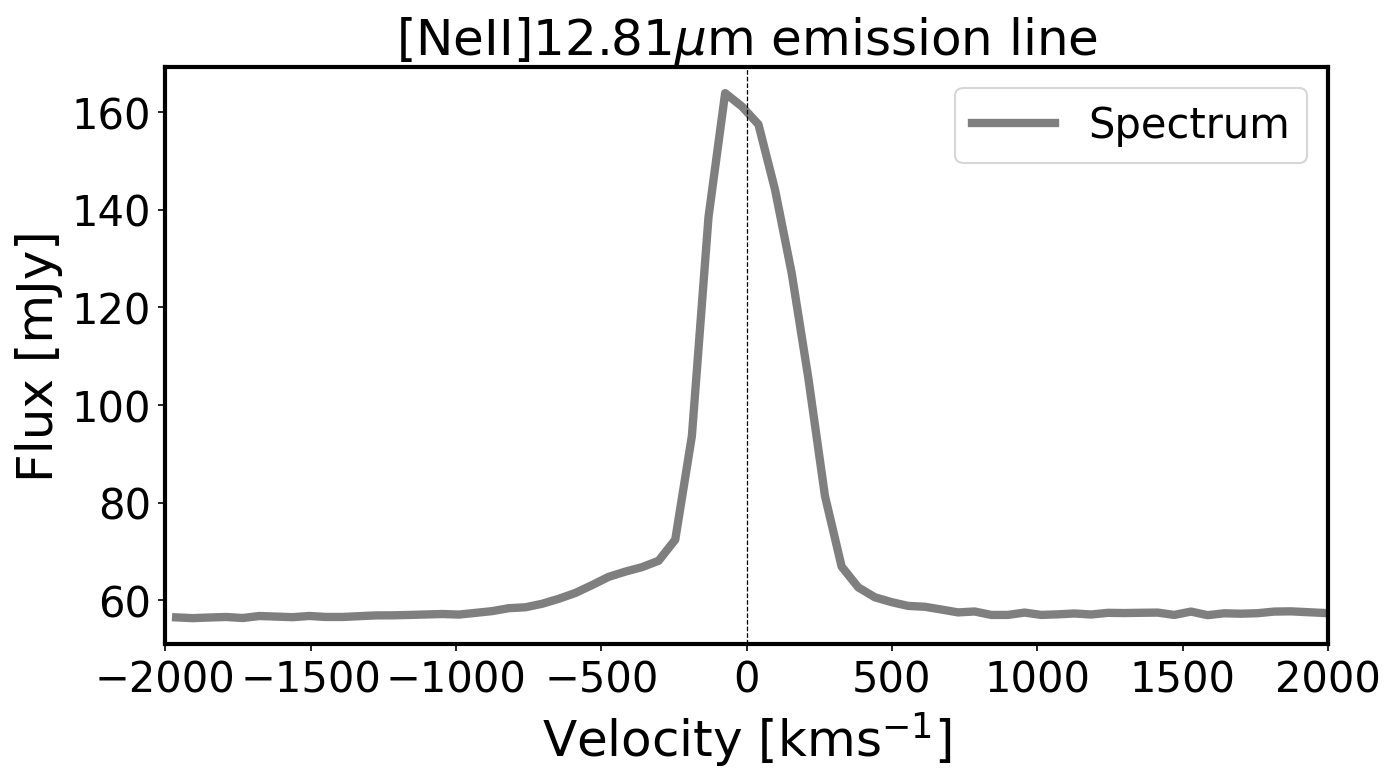

In [8]:
rc('axes', linewidth=2)
fig, axs = plt.subplots(1, 1, figsize=(10, 5), dpi=150)

axs.plot(x_velocity_range, y_flux_range, color='tab:gray', linewidth=4., label='Spectrum')
axs.axvline(x = 0, color = 'k', linestyle='--', linewidth=0.6)

axs.set_xlim(min_velocity,max_velocity)

axs.tick_params(axis="x", labelsize=20)
axs.tick_params(axis="y", labelsize=20)
axs.legend(fontsize=20)

axs.set_title(r'{}{}$\mu$m emission line'.format(name_line,str(np.round(lambda_line,decimals=2))), fontsize = 24)
axs.set_ylabel(r'Flux [mJy]', fontsize=24)
axs.set_xlabel(r'Velocity [kms$^{-1}$]', fontsize=24)

plt.savefig(dir_output + 'NGC7913_{}_line.pdf'.format(name_line),format='pdf',bbox_inches='tight')

plt.show()

## 4. Emission line fitting and flux calculation
This section performs an emission line fitting, and derives the flux and FWHM. It allows to use two different functions: 
* One gaussian component with a linear continuum
* Two Gaussian components with a linear continuum

Please, if you want to analyze a different emission lines, you should run this section again modifing the parameters of Section 4.1

#### 4.1 Define the parameters of the emission line

In [9]:
# Define the emission line that you whould like to visualize
#name_line = 'H2(0-0)S(5)'   
#lambda_line =  6.90952 # um

# Which does MRS channel contain the emission line?
#channel_line = '1'   # 1, 2, 3, or 4
#band_line = 'LONG'  # SHORT, MEDIUM, or LONG 

# How many Gaussian components do you want to fit? 
Gaussina_comp = '1' # '1' or '2' 

# Define the range in velocity used to perform the fit
min_velocity = -2000 # km/s
max_velocity = 2000  # km/s

# Define initial parameteres for the two gaussian fit
## Narrow component
FWHM_narrow_init = 300 # km/s
## Broad component
FWHM_broad_init = 600 #km/s
offset_broad_init = -200 #km/s

# Define the range in velocity used to plot fit
min_velocity_plot = -2000 # km/s
max_velocity_plot = 2000  # km/s

#### Define the functions to model the emission line 

In [10]:
# This will model the emission line with two Gaussian funtions and a continuum
def func_gaussian_2comp(x,p):
    
    f1 = p[0] * np.exp(-(x-p[1])**2/(2*(p[2]**2)))
    f2 = p[3] * np.exp(-(x-(p[1]+p[4]))**2/(2*(p[5]**2)))  
    f3 = p[6] + p[7]*x
    f = f1 + f2 + f3
    return f

def myfunc_gaussian_2comp(p, fjac=None, x=None, y=None, err=None):
    model = func_gaussian_2comp(x,p)
    status = 0
    return [status, (y-model)/err]

def func_gaussian_1comp(x,p):
    
    f1 = p[0] * np.exp(-(x-p[1])**2/(2*(p[2]**2)))
    f2 = p[3] + p[4]*x
    f = f1 + f2
    return f

def myfunc_gaussian_1comp(p, fjac=None, x=None, y=None, err=None):
    model = func_gaussian_1comp(x,p)
    status = 0
    return [status, (y-model)/err]

def plot_gaussian_1comp(x,p):
    f = p[0] * np.exp(-(x-p[1])**2/(2*(p[2]**2))) 
    return f

#### 4.3 Load the spectrum and set up the diferent parameters to plot the emision line

In [11]:
# Load the spectrum 
file = dir_1Dspectra + 'Level3_ch{}-{}_x1d.fits'.format(channel_line, band_line.lower())
x1d=fits.open(file)
x1ddata=x1d[1].data
lambda_obs=x1ddata['WAVELENGTH'] # um
flux=x1ddata['FLUX'] * 1.e+3 #mJy

# Central observed lambda for the selected emission line
lambda_obs_line = lambda_line * (1+redshift)

# transform the lambda array to a velocity array centered on the peak of the emission line
x_velocity = 3.e+5 * (lambda_obs - lambda_obs_line)/lambda_obs_line

# select the range of the spectra to visualize
id_velocity = np.where(np.logical_and(x_velocity >= min_velocity, x_velocity <= max_velocity))
lambda_obs_range = lambda_obs[id_velocity]
x_velocity_range = x_velocity[id_velocity]
y_flux_nu_range = flux[id_velocity]
y_flux_lambda_range = 1.e-26 * y_flux_nu_range * 3.e+14 / (lambda_obs_range*lambda_obs_range) #erg/s/cm2/um

#### 4.4 Fit the emission line

In [12]:
#Normalize the spectrum to 1 for the line fitting
norm_factor = np.max(y_flux_lambda_range)
y_flux_lambda_range_norm = y_flux_lambda_range/norm_factor

#transform the FWHM and offset init to lambda
sigma_narrow_lamb_init = FWHM_narrow_init * lambda_obs_line /(3.e+5 * 2.35482)
sigma_broad_lamb_init = FWHM_broad_init * lambda_obs_line /(3.e+5 * 2.35482)
offset_lamb_init = offset_broad_init * lambda_obs_line/3.e+5

# Perform a fit to the emission line with a gaussian + background (line)
if Gaussina_comp == '1':

    # Define the initial parameters
    start_param = np.array([0.6, lambda_obs_line, sigma_narrow_lamb_init, 0., 0.], dtype='float64') 
    # define the bounds
    parbase={'value':0., 'fixed':0, 'limited':[0,0], 'limits':[0.,0.]}
    parinfo=[]

    for k in range(len(start_param)):
        parinfo.append(copy.deepcopy(parbase))
    
    parinfo[0]['limited'] = [1, 1]
    parinfo[0]['limits'] = [0.2, 1.]
    parinfo[1]['limited'] = [1, 1]
    parinfo[1]['limits'] = [lambda_obs_line - 200 * lambda_obs_line/3.e+5, lambda_obs_line + 200 * lambda_obs_line/3.e+5 ]
    parinfo[2]['limited'] = [1, 1]
    parinfo[2]['limits'] = [0., 400 * lambda_obs_line/3.e+5]
    parinfo[3]['limited'] = [1, 1]
    parinfo[3]['limits'] = [-1000, 1000]
    parinfo[4]['limited'] = [1, 1]
    parinfo[4]['limits'] = [-1000, 1000]
    # Define the fitting functions
    error = lambda_obs_range*0 + 1
    fa = {'x':lambda_obs_range, 'y':y_flux_lambda_range_norm, 'err':error}
    # Perform the fit

    param_fit = mpfit(myfunc_gaussian_1comp, start_param, parinfo=parinfo, functkw=fa, quiet=True)

if Gaussina_comp == '2':

    # Define the initial parameters
    start_param = np.array([0.6, lambda_obs_line, sigma_narrow_lamb_init, 0.3, offset_lamb_init, sigma_broad_lamb_init, 0., 0.], dtype='float64') 
    # define the bounds
    parbase={'value':0., 'fixed':0, 'limited':[0,0], 'limits':[0.,0.]}
    parinfo=[]

    for k in range(len(start_param)):
        parinfo.append(copy.deepcopy(parbase))
    
    parinfo[0]['limited'] = [1, 1]
    parinfo[0]['limits'] = [0.2, 1.]
    parinfo[1]['limited'] = [1, 1]
    parinfo[1]['limits'] = [lambda_obs_line - 200 * lambda_obs_line/3.e+5, lambda_obs_line + 200 * lambda_obs_line/3.e+5 ]
    parinfo[2]['limited'] = [1, 1]
    parinfo[2]['limits'] = [0., 400 * lambda_obs_line/3.e+5]
    parinfo[3]['limited'] = [1, 1]
    parinfo[3]['limits'] = [0, 0.5]
    parinfo[4]['limited'] = [1, 1]
    parinfo[4]['limits'] = [-1000. * lambda_obs_line/3.e+5, 1000.* lambda_obs_line/3.e+5]
    parinfo[5]['limited'] = [1, 1]
    parinfo[5]['limits'] = [200 * lambda_obs_line/3.e+5, 5000 * lambda_obs_line/3.e+5]
    parinfo[6]['limited'] = [1, 1]
    parinfo[6]['limits'] = [-1000, 1000]
    parinfo[7]['limited'] = [1, 1]
    parinfo[7]['limits'] = [-1000, 1000]
    # Define the fitting functions
    error = lambda_obs_range*0 + 1
    fa = {'x':lambda_obs_range, 'y':y_flux_lambda_range_norm, 'err':error}
    # Perform the fit

    param_fit = mpfit(myfunc_gaussian_2comp, start_param, parinfo=parinfo, functkw=fa, quiet=True)

#### 4.5 Vizualize the emission line fitting

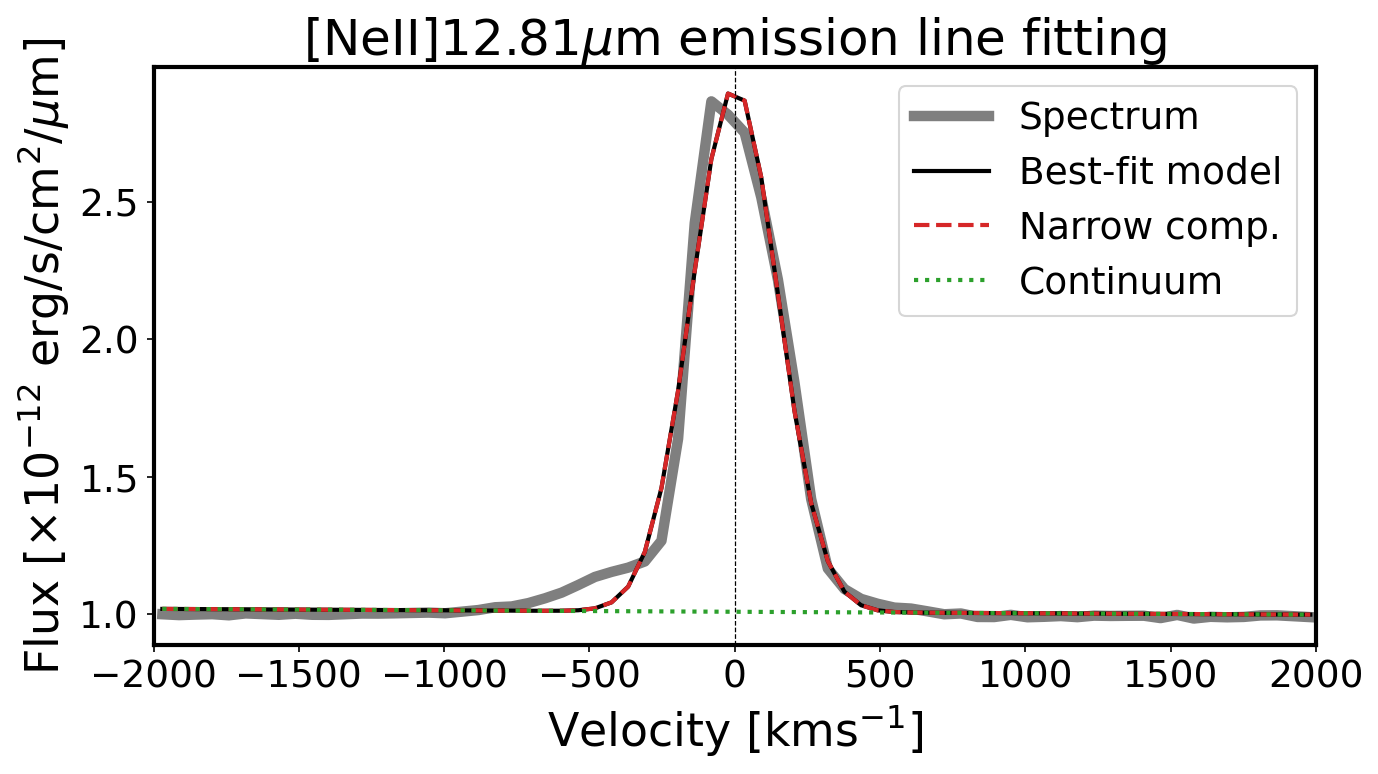

In [13]:
rc('axes', linewidth=2)
fig, axs = plt.subplots(1, 1, figsize=(10, 5), dpi=150)

if  Gaussina_comp == '1':
    new_velocity_cent_narrow = 3.e+5 * (lambda_obs_range - param_fit.params[1])/param_fit.params[1]
    y_model = func_gaussian_1comp(lambda_obs_range,param_fit.params)*norm_factor*1.e+12
    y_GaussComp_narrow = (plot_gaussian_1comp(lambda_obs_range, np.array([param_fit.params[0],param_fit.params[1],param_fit.params[2]])) + param_fit.params[3] + param_fit.params[4]*lambda_obs_range)*norm_factor*1.e+12
    y_cont = (param_fit.params[3] + param_fit.params[4]*lambda_obs_range)*norm_factor*1.e+12

    axs.plot(new_velocity_cent_narrow, y_flux_lambda_range/1.e-12, color='tab:gray', linewidth=5., label='Spectrum')
    axs.plot(new_velocity_cent_narrow, y_model, color='k', linewidth=2., label='Best-fit model')
    axs.plot(new_velocity_cent_narrow, y_GaussComp_narrow, color='tab:red', linewidth=2., linestyle='--', label='Narrow comp.')
    axs.plot(new_velocity_cent_narrow, y_cont, color='tab:green', linewidth=2., linestyle='dotted', label='Continuum')

if  Gaussina_comp == '2':
    new_velocity_cent_narrow = 3.e+5 * (lambda_obs_range - param_fit.params[1])/param_fit.params[1]
    y_model = func_gaussian_2comp(lambda_obs_range,param_fit.params)*norm_factor*1.e+12
    y_GaussComp_narrow = (plot_gaussian_1comp(lambda_obs_range, np.array([param_fit.params[0],param_fit.params[1],param_fit.params[2]])) + param_fit.params[6] + param_fit.params[7]*lambda_obs_range)*norm_factor*1.e+12
    y_GaussComp_broad = (plot_gaussian_1comp(lambda_obs_range, np.array([param_fit.params[3],param_fit.params[1]+param_fit.params[4],param_fit.params[5]])) + param_fit.params[6] + param_fit.params[7]*lambda_obs_range)*norm_factor*1.e+12
    y_cont = (param_fit.params[6] + param_fit.params[7]*lambda_obs_range)*norm_factor*1.e+12

    axs.plot(new_velocity_cent_narrow, y_flux_lambda_range/1.e-12, color='tab:gray', linewidth=5., label='Spectrum')
    axs.plot(new_velocity_cent_narrow, y_model, color='k', linewidth=2., label='Best-fit model')
    axs.plot(new_velocity_cent_narrow, y_GaussComp_narrow, color='tab:red', linewidth=2., linestyle='--', label='Narrow comp.')
    axs.plot(new_velocity_cent_narrow, y_GaussComp_broad, color='tab:blue', linewidth=2., linestyle='--', label='Broad comp.')
    axs.plot(new_velocity_cent_narrow, y_cont, color='tab:green', linewidth=2., linestyle='dotted', label='Continuum')
    
axs.axvline(x = 0, color = 'k', linestyle='--', linewidth=0.6)

axs.set_xlim(min_velocity_plot,max_velocity_plot)

axs.tick_params(axis="x", labelsize=18)
axs.tick_params(axis="y", labelsize=18)
axs.legend(fontsize=18)

axs.set_title(r'{}{}$\mu$m emission line fitting'.format(name_line,str(np.round(lambda_line,decimals=2))), fontsize = 24)
axs.set_ylabel(r'Flux [$\times$10$^{-12}$ erg/s/cm$^{2}$/$\mu$m]', fontsize=22)
axs.set_xlabel(r'Velocity [kms$^{-1}$]', fontsize=22)

plt.savefig(dir_output + 'NGC7913_{}_line.pdf'.format(name_line),format='pdf',bbox_inches='tight')

plt.show()

#### 4.6 Results of the emission line fitting

In [14]:
if  Gaussina_comp == '1':
    lambda_line_fit_obs = param_fit.params[1]
    flux_total = norm_factor * param_fit.params[0] * np.sqrt(2 * np.pi * param_fit.params[2]**2)
    FWHM_total = 3.e+5 * 2.35482 * param_fit.params[2] / param_fit.params[1]

    print('##################################################################')        
    print(r'{}{}um emission line fitting results using {} Gaussian comp.'.format(name_line,str(np.round(lambda_line,decimals=2)),Gaussina_comp))
    print('##################################################################')
    print('')
    print('Flux total      [erg/s/cm2]  = ', flux_total)
    print('FWHM            [km/s]       = ', np.round(FWHM_total, decimals=1))

if  Gaussina_comp == '2':
    lambda_line_fit_obs = param_fit.params[1]
    flux_narrow = norm_factor * param_fit.params[0] * np.sqrt(2 * np.pi * param_fit.params[2]**2)
    flux_broad = norm_factor * param_fit.params[3] * np.sqrt(2 * np.pi * param_fit.params[5]**2)
    flux_total = flux_narrow + flux_broad
    FWHM_narrow = 3.e+5 * 2.35482 * param_fit.params[2] / param_fit.params[1]
    FWHM_broad = 3.e+5 * 2.35482 * param_fit.params[5] / param_fit.params[1]
    offset_broad = - 3.e+5 * param_fit.params[4] / param_fit.params[1]

    print('##################################################################')        
    print(r'{}{}um emission line fitting results using {} Gaussian comp.'.format(name_line,str(np.round(lambda_line,decimals=2)),Gaussina_comp))
    print('##################################################################')
    print('')
    print('Flux total                  [erg/s/cm2]  = ', flux_total)
    print('Flux narrow comp.           [erg/s/cm2]  = ', flux_narrow)
    print('Flux broad comp.            [erg/s/cm2]  = ', flux_broad)
    print('FWHM narrow comp.           [km/s]       = ', np.round(FWHM_narrow, decimals=1))
    print('FWHM broad comp.            [km/s]       = ', np.round(FWHM_broad, decimals=1))
    print('Velocity offset broad comp. [km/s]       = ', np.round(offset_broad, decimals=1))

##################################################################
[NeII]12.81um emission line fitting results using 1 Gaussian comp.
##################################################################

Flux total      [erg/s/cm2]  =  3.097324039885568e-14
FWHM            [km/s]       =  349.2


## 5. Emission line map
Please, if you want to generate line maps of different emission lines, you should run this section again modifing the parameters of Section 5.1

#### 5.1 Define the parameters of the emission line

In [15]:
# Define the emission line that you whould like to visualize
#name_line = '[NeII]'   
#lambda_line =  12.813550 # um

# Which does MRS channel contain the emission line?
#channel_line = '3'   # 1, 2, 3, or 4
#band_line = 'SHORT'  # SHORT, MEDIUM, or LONG 

# Define the range in velocity that you will use to integrate the emission line
min_velocity_line = -1000 # km/s
max_velocity_line =  600  # km/s

# Define the range in velocity that you will use to calculate the continuum
min_velocity_cont_less = -3000 # km/s
max_velocity_cont_less = -1500  # km/s
min_velocity_cont_plus = 1500 # km/s
max_velocity_cont_plus = 3000  # km/s

# Define the range in velocity that you will use to integrate the emission line
min_velocity_plot = -3500 # km/s
max_velocity_plot = 3500  # km/s

#### Load the 1D spectrum and 3D spectral cube

In [16]:
# Load the spectrum 
file = dir_1Dspectra + 'Level3_ch{}-{}_x1d.fits'.format(channel_line, band_line.lower())
x1d=fits.open(file)
x1ddata=x1d[1].data
lambda_obs=x1ddata['WAVELENGTH'] # um
flux=x1ddata['FLUX'] * 1.e+3 #mJy

# Load the cube
file_cube = dir_MRScubes + 'Level3_ch{}-{}_s3d.fits'.format(channel_line, band_line.lower())
with fits.open(file_cube) as hdul:
    # Read Cube parameters
    NAXIS1 = hdul['SCI'].header['NAXIS1']
    NAXIS2 = hdul['SCI'].header['NAXIS2']
    NAXIS3 = hdul['SCI'].header['NAXIS3']
    CDELT1 = np.abs(hdul['SCI'].header['CDELT1'])
    CDELT2 = np.abs(hdul['SCI'].header['CDELT2'])
    CDELT3 = np.abs(hdul['SCI'].header['CDELT3'])
    CRVAL_3 = hdul['SCI'].header['CRVAL3']

    lambda_cube = np.arange(NAXIS3) * CDELT3 + CRVAL_3
    
    cube = hdul['SCI'].data    

#### Plot the emission line and the areas for the background and emission line

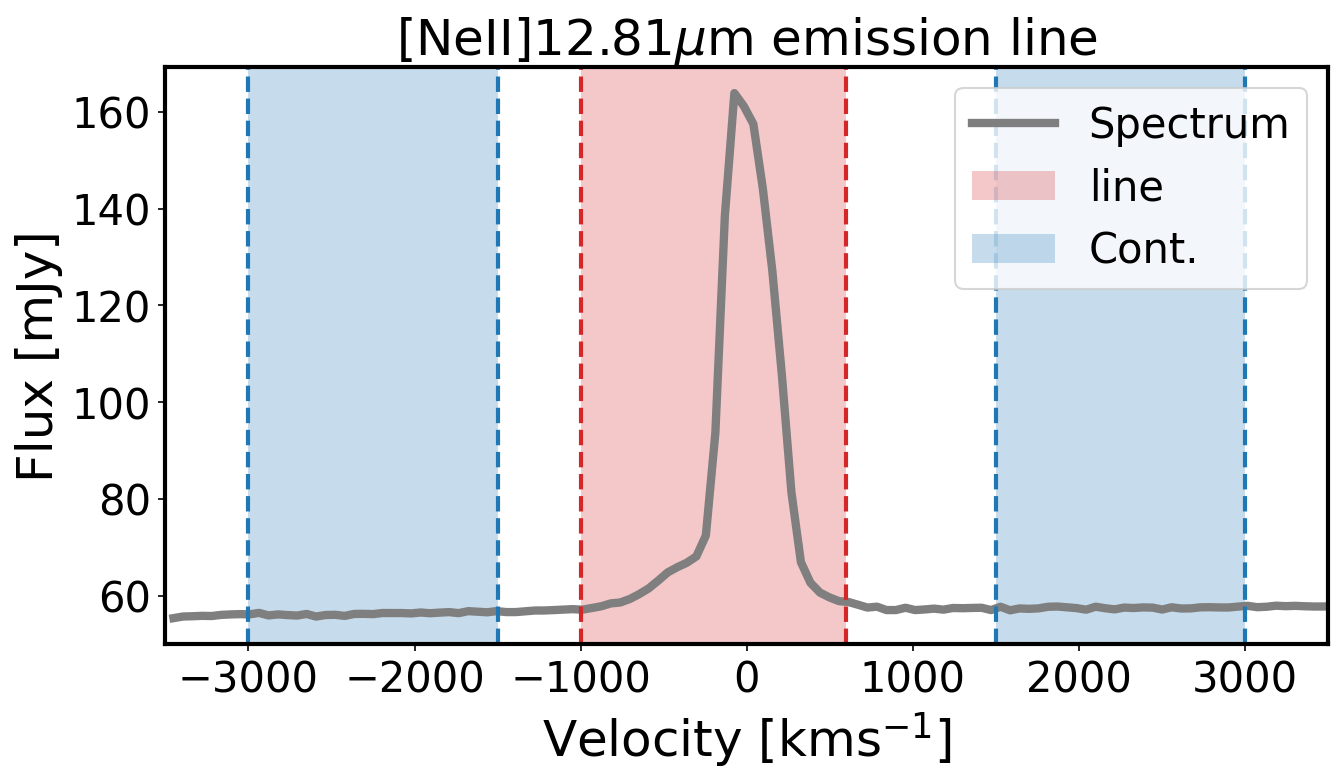

In [17]:
# Central observed lambda for the selected emission line
lambda_obs_line = lambda_line * (1+redshift)

# transform the lambda array to a velocity array centered on the peak of the emission line
x_velocity = 3.e+5 * (lambda_obs - lambda_obs_line)/lambda_obs_line

# select the range of the spectra to visualize
id_velocity = np.where(np.logical_and(x_velocity >= min_velocity_plot, x_velocity <= max_velocity_plot))
x_velocity_range = x_velocity[id_velocity]
y_flux_range = flux[id_velocity]

rc('axes', linewidth=2)
fig, axs = plt.subplots(1, 1, figsize=(10, 5), dpi=150)

axs.plot(x_velocity_range, y_flux_range, color='tab:gray', linewidth=4., label='Spectrum')
axs.axvline(x = min_velocity_line, color = 'tab:red', linestyle='--', linewidth=2)
axs.axvline(x = max_velocity_line, color = 'tab:red', linestyle='--', linewidth=2)
axs.axvspan(min_velocity_line, max_velocity_line, facecolor='tab:red', alpha=0.25, label='line')

axs.axvline(x = min_velocity_cont_less, color = 'tab:blue', linestyle='--', linewidth=2)
axs.axvline(x = max_velocity_cont_less, color = 'tab:blue', linestyle='--', linewidth=2)
axs.axvspan(min_velocity_cont_less, max_velocity_cont_less, facecolor='tab:blue', alpha=0.25)

axs.axvline(x = min_velocity_cont_plus, color = 'tab:blue', linestyle='--', linewidth=2)
axs.axvline(x = max_velocity_cont_plus, color = 'tab:blue', linestyle='--', linewidth=2)
axs.axvspan(min_velocity_cont_plus, max_velocity_cont_plus, facecolor='tab:blue', alpha=0.25, label='Cont.')

axs.set_xlim(min_velocity_plot,max_velocity_plot)

axs.tick_params(axis="x", labelsize=20)
axs.tick_params(axis="y", labelsize=20)
axs.legend(fontsize=20)

axs.set_title(r'{}{}$\mu$m emission line'.format(name_line,str(np.round(lambda_line,decimals=2))), fontsize = 24)
axs.set_ylabel(r'Flux [mJy]', fontsize=24)
axs.set_xlabel(r'Velocity [kms$^{-1}$]', fontsize=24)

#plt.savefig(dir_output + 'NGC7913_{}_line.pdf'.format(name_line),format='pdf',bbox_inches='tight')

plt.show()

#### Generae the line map image

In [18]:
# transform the lambda array to a velocity array centered on the peak of the emission line
x_velocity_cube = 3.e+5 * (lambda_cube - lambda_obs_line)/lambda_obs_line

# select the range of the spectra to visualize
id_cube_line = np.where(np.logical_and(x_velocity_cube >= min_velocity_line, x_velocity_cube <= max_velocity_line))
id_cube_cont_less = np.where(np.logical_and(x_velocity_cube >= min_velocity_cont_less, x_velocity_cube <= max_velocity_cont_less))
id_cube_cont_plus = np.where(np.logical_and(x_velocity_cube >= min_velocity_cont_plus, x_velocity_cube <= max_velocity_cont_plus))

#Colapse cube in lambda direcction
image_2D_line=np.zeros((NAXIS2, NAXIS1))
image_2D_cont_less=np.zeros((NAXIS2, NAXIS1))
image_2D_cont_plus=np.zeros((NAXIS2, NAXIS1))
image_2D_cont_full_channel=np.zeros((NAXIS2, NAXIS1))
for ii in range(NAXIS1):
    for jj in range(NAXIS2):
        image_2D_line[jj,ii]=np.nansum(cube[id_cube_line,jj,ii])
        image_2D_cont_less[jj,ii]=np.nanmedian(cube[id_cube_cont_less,jj,ii]) 
        image_2D_cont_plus[jj,ii]=np.nanmedian(cube[id_cube_cont_plus,jj,ii]) 
        image_2D_cont_full_channel[jj,ii]=np.nanmedian(cube[:,jj,ii]) 
        
image_2D_cont = (image_2D_cont_less + image_2D_cont_plus)/2.

image_2D_line_nocont = image_2D_line - len(id_cube_line) * image_2D_cont
image_2D_line_nocont_norm = image_2D_line_nocont/np.nanmax(image_2D_line_nocont)

/tmp/ipykernel_8463/2325347513.py:17: RuntimeWarning: All-NaN slice encountered
  image_2D_cont_less[jj,ii]=np.nanmedian(cube[id_cube_cont_less,jj,ii])
/tmp/ipykernel_8463/2325347513.py:18: RuntimeWarning: All-NaN slice encountered
  image_2D_cont_plus[jj,ii]=np.nanmedian(cube[id_cube_cont_plus,jj,ii])
/tmp/ipykernel_8463/2325347513.py:19: RuntimeWarning: All-NaN slice encountered
  image_2D_cont_full_channel[jj,ii]=np.nanmedian(cube[:,jj,ii])


#### Plot the emission line map

In [19]:
def limits_plot_color(image):
    interval = vis.PercentileInterval(97)
    vmin,vmax = interval.get_limits(image)
    norm = vis.ImageNormalize(vmin=vmin, vmax=vmax, stretch=vis.SqrtStretch())
    
    return norm

/tmp/ipykernel_8463/1173974212.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(ticklabs, fontsize=20)
/tmp/ipykernel_8463/1173974212.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pixHx=np.arange(-med[0]+med[0]%jumpix,med[0],jumpix)
/tmp/ipykernel_8463/1173974212.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pixHy=np.arange(-med[1]+med[1]%jumpix,med[1],jumpix)


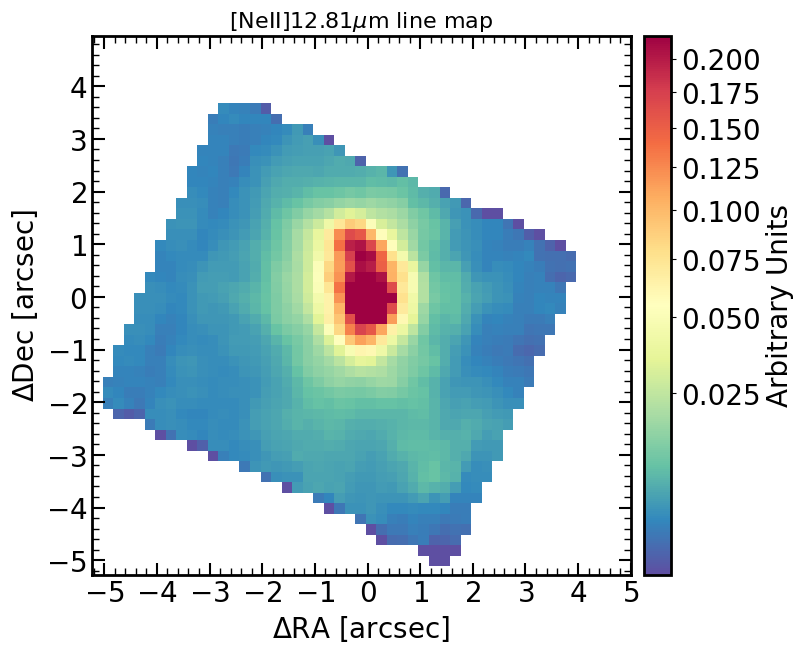

In [20]:
aspect = 20
pad_fraction = 0.5

fig, ax = plt.subplots(1, 1, figsize=(10,7))

norm = limits_plot_color(image_2D_line_nocont_norm)
plot_1 = ax.imshow(image_2D_line_nocont_norm, cmap=plt.cm.Spectral_r, origin='lower',norm = norm)
divider = make_axes_locatable(ax)
width = axes_size.AxesY(ax, aspect=1./aspect)
pad = axes_size.Fraction(pad_fraction, width)
cax = divider.append_axes("right", size=width, pad=pad)
cbar = plt.colorbar(plot_1, cax=cax, label='Arbitrary Units')
ticklabs = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(ticklabs, fontsize=20)
ticklabs = cbar.ax.get_ylabel()
cbar.ax.set_ylabel(ticklabs, fontsize=20)

ax.set_title(r'{}{}$\mu$m line map'.format(name_line,str(np.round(lambda_line,decimals=2))), size=16) 

id_max = np.where(image_2D_cont_full_channel == np.nanmax(image_2D_cont_full_channel))
x_centroid, y_centroid = centroid_sources(image_2D_cont_full_channel, id_max[1], id_max[0], box_size=7, centroid_func=centroid_2dg)  

ax.set_box_aspect(1)
med=[y_centroid,x_centroid]  
jump=1. #arcsec
jumpix=jump/(CDELT1*3600.)
pixHx=np.arange(-med[0]+med[0]%jumpix,med[0],jumpix)
pixHy=np.arange(-med[1]+med[1]%jumpix,med[1],jumpix)
ax.set_yticks(pixHx+med[0])
ax.set_yticklabels(["$%d$"%f for f in np.round(pixHx*(CDELT1*3600.),0).astype('int')], fontsize=20)
ax.set_xticks(pixHy+med[1])
ax.set_xticklabels(["$%d$"%f for f in np.round(pixHy*(CDELT1*3600.),0).astype('int')], fontsize=20)
ax.minorticks_on()
ax.tick_params(direction='in',color='k',length=9,width=1.5,top='True',right='True',which='major')
ax.tick_params(direction='in',color='k',length=5,width=1,top='True',right='True',which='minor')

ax.set_ylabel('$\Delta$Dec [arcsec]', size=20)
ax.set_xlabel('$\Delta$RA [arcsec]', size=20)

plt.savefig(dir_output + 'NGC7913_{}_linemap.pdf'.format(name_line),format='pdf',bbox_inches='tight')

plt.show()